Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/machine-learning-pipelines/intro-to-pipelines/aml-pipelines-parameter-tuning-with-hyperdrive.png)

# Azure Machine Learning Pipeline with HyperDriveStep


This notebook is used to demonstrate the use of HyperDriveStep in AML Pipeline.

## Prerequisites and Azure Machine Learning Basics
If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the [configuration Notebook](https://aka.ms/pl-config) first if you haven't. This sets you up with a working config file that has information on your workspace, subscription id, etc. 

## Azure Machine Learning and Pipeline SDK-specific imports

In [3]:
import azureml.core
from azureml.core import Workspace, Environment, Experiment, Datastore, Dataset, ScriptRunConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import RunConfiguration
from azureml.exceptions import ComputeTargetException
from azureml.pipeline.steps import HyperDriveStep, HyperDriveStepRun, PythonScriptStep
from azureml.pipeline.core import Pipeline, PipelineData, TrainingOutput
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

import os
import shutil
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.27.0


## Initialize workspace

Initialize a workspace object from persisted configuration. If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure the config file is present at .\config.json

In [4]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

distributeddeeplearningqmx
deep-learning-challenge
westus2
3df1840f-dd4b-4f54-a831-e20536439b3a


## Create an Azure ML experiment
Let's create an experiment named "tf-mnist" and a folder to hold the training scripts. 

> The best practice is to use separate folders for scripts and its dependent files for each step. This helps reduce the size of the snapshot created for the step (only the specific folder is snapshotted). Since changes in any files in the `source_directory` would trigger a re-upload of the snapshot, this helps keep the reuse of the step when there are no changes in the `source_directory` of the step. 

> The script runs will be recorded under the experiment in Azure.

In [5]:
script_folder = './tf-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='Hyperdrive_sample')

## Download MNIST dataset
In order to train on the MNIST dataset we will first need to download it from Yan LeCun's web site directly and save them in a `data` folder locally.

In [6]:
data_folder = os.path.join(os.getcwd(), 'data/mnist')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'test-labels.gz'))

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/dbconnect/code/Users/hosarsha/machine-learning-pipelines/intro-to-pipelines/data/mnist/test-labels.gz',
 <http.client.HTTPMessage at 0x7fbca6489f98>)

## Show some sample images
Let's load the downloaded compressed file into numpy arrays using some utility functions included in the `utils.py` library file from the current folder. Then we use `matplotlib` to plot 30 random images from the dataset along with their labels.

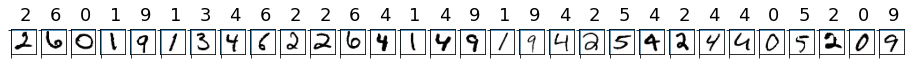

In [7]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / np.float32(255.0)
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / np.float32(255.0)
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)


count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

## Upload MNIST dataset to blob datastore 
A [datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data) is a place where data can be stored that is then made accessible to a Run either by means of mounting or copying the data to the compute target. In the next step, we will use Azure Blob Storage and upload the training and test set into the Azure Blob datastore, which we will then later be mount on a Batch AI cluster for training.

In [8]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading an estimated of 4 files
Uploading ./data/mnist/test-images.gz
Uploaded ./data/mnist/test-images.gz, 1 files out of an estimated total of 4
Uploading ./data/mnist/test-labels.gz
Uploaded ./data/mnist/test-labels.gz, 2 files out of an estimated total of 4
Uploading ./data/mnist/train-images.gz
Uploaded ./data/mnist/train-images.gz, 3 files out of an estimated total of 4
Uploading ./data/mnist/train-labels.gz
Uploaded ./data/mnist/train-labels.gz, 4 files out of an estimated total of 4
Uploaded 4 files


$AZUREML_DATAREFERENCE_f214ffab50e74ba58573a9406638eb58

## Create Azure Machine Learning datasets
By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred.

In [9]:
dataset = Dataset.File.from_files(datastore.path('mnist'))

## Retrieve or create a Azure Machine Learning compute
Azure Machine Learning Compute is a service for provisioning and managing clusters of Azure virtual machines for running machine learning workloads. Let's create a new Azure Machine Learning Compute in the current workspace, if it doesn't already exist. We will then run the training script on this compute target.

If we could not find the compute with the given name in the previous cell, then we will create a new compute here. This process is broken down into the following steps:

1. Create the configuration
2. Create the Azure Machine Learning compute

**This process will take a few minutes and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell.**


In [10]:
cluster_name = "v100-1-g-1-n"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target {}.'.format(cluster_name))
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_NC6",
                                                               max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True, timeout_in_minutes=20)

print("Azure Machine Learning Compute attached")

cpu_cluster_name = "cpu-cluster"

try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpu-cluster")
except ComputeTargetException:
    print("Creating new cpu-cluster")
    
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                           min_nodes=0,
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
cpu_cluster.wait_for_completion(show_output=True)

Found existing compute target v100-1-g-1-n.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
Azure Machine Learning Compute attached
Found existing cpu-cluster
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Copy the training files into the script folder
The TensorFlow training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [11]:
# the training logic is in the tf_mnist.py file.
shutil.copy('./tf_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./tf-mnist/utils.py'

## Retrieve an Environment
In this tutorial, we will use one of Azure ML's curated TensorFlow environments for training. Curated environments are available in your workspace by default. Specifically, we will use the TensorFlow 2.0 GPU curated environment.

In [12]:
tf_env = Environment.get(ws, name='AzureML-TensorFlow-2.0-GPU')

### Setup an input for the ScriptRunConfig step
You can mount dataset to remote compute.

In [13]:
data_folder = dataset.as_mount()

## Configure the training job
Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on

In [14]:
src = ScriptRunConfig(source_directory=script_folder,
                      script='tf_mnist.py',
                      arguments=['--data-folder', data_folder],
                      compute_target=compute_target,
                      environment=tf_env)

## Intelligent hyperparameter tuning
Now let's try hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In this example we will use random sampling to try different configuration sets of hyperparameters to maximize our primary metric, the best validation accuracy (`validation_acc`).

In [15]:
ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

Refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-tune-hyperparameters#specify-an-early-termination-policy) for more information on the BanditPolicy and other policies available.

In [16]:
early_termination_policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `validation_acc` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [17]:
hd_config = HyperDriveConfig(run_config=src, 
                             hyperparameter_sampling=ps,
                             policy=early_termination_policy,
                             primary_metric_name='validation_acc', 
                             primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                             max_total_runs=4,
                             max_concurrent_runs=4)

### HyperDriveStep
HyperDriveStep can be used to run HyperDrive job as a step in pipeline.
- **name:** Name of the step
- **hyperdrive_config:** A HyperDriveConfig that defines the configuration for this HyperDrive run
- **inputs:** List of input port bindings
- **outputs:** List of output port bindings
- **metrics_output:** Optional value specifying the location to store HyperDrive run metrics as a JSON file
- **allow_reuse:** whether to allow reuse
- **version:** version


In [18]:
metrics_output_name = 'metrics_output'
metrics_data = PipelineData(name='metrics_data',
                            datastore=datastore,
                            pipeline_output_name=metrics_output_name,
                            training_output=TrainingOutput("Metrics"))

model_output_name = 'model_output'
saved_model = PipelineData(name='saved_model',
                            datastore=datastore,
                            pipeline_output_name=model_output_name,
                            training_output=TrainingOutput("Model",
                                                           model_file="outputs/model/saved_model.pb"))

hd_step_name='hd_step01'
hd_step = HyperDriveStep(
    name=hd_step_name,
    hyperdrive_config=hd_config,
    inputs=[data_folder],
    outputs=[metrics_data, saved_model])

## Find and register best model
When all the jobs finish, we can choose to register the model that has the highest accuracy through an additional PythonScriptStep.

Through this additional register_model_step, we register the chosen files as a model named `tf-dnn-mnist` under the workspace for deployment.

In [19]:
conda_dep = CondaDependencies()
conda_dep.add_pip_package("azureml-sdk")

rcfg = RunConfiguration(conda_dependencies=conda_dep)

register_model_step = PythonScriptStep(script_name='register_model.py',
                                       name="register_model_step01",
                                       inputs=[saved_model],
                                       compute_target=cpu_cluster,
                                       arguments=["--saved-model", saved_model],
                                       allow_reuse=True,
                                       runconfig=rcfg)

register_model_step.run_after(hd_step)

### Run the pipeline

In [ ]:
pipeline = Pipeline(workspace=ws, steps=[hd_step, register_model_step])
pipeline_run = exp.submit(pipeline)

### Monitor using widget

In [ ]:
from azureml.widgets import RunDetails
RunDetails(pipeline_run).show()

### Wait for the completion of this Pipeline run

In [ ]:
pipeline_run.wait_for_completion()

### Retrieve the metrics
Outputs of above run can be used as inputs of other steps in pipeline. In this tutorial, we will show the result metrics.

In [ ]:
metrics_output = pipeline_run.get_pipeline_output(metrics_output_name)
num_file_downloaded = metrics_output.download('.', show_progress=True)

In [ ]:
import pandas as pd
import json
with open(metrics_output._path_on_datastore) as f:  
    metrics_output_result = f.read()
    
deserialized_metrics_output = json.loads(metrics_output_result)
df = pd.DataFrame(deserialized_metrics_output)
df

For model deployment, please refer to [Training, hyperparameter tune, and deploy with TensorFlow](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/ml-frameworks/tensorflow/train-hyperparameter-tune-deploy-with-tensorflow/train-hyperparameter-tune-deploy-with-tensorflow.ipynb).